In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization = ResNet
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization = ResNet
])


In [3]:
# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=' ./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Split training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Data Loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
def imshow(img):
    """Show an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


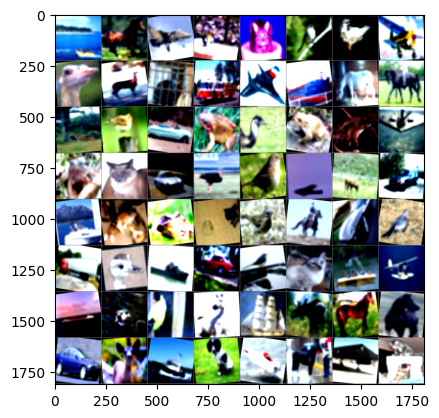

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

## RESNET18

In [6]:
import torchvision.models as models
import torch.nn as nn


resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Final classification layer to 10 classes
num_labels = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_labels, 10)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

resnet18 = resnet18.to(device)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import copy


def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    num_epochs=25,
):
    """Train the model and return the best version based on validation accuracy."""

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
        )

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.show()

    return model, best_acc, train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_info_resnet18 = train_model(
    resnet18,
    criterion,
    optimizer,
    scheduler,
    trainloader,
    valloader,
    num_epochs=25,
)

# resnet18 = train_info_resnet18[0]
torch.save(resnet18.state_dict(), "resnet18_mps.pth")

Epoch 1/25, Train Loss: 0.6359, Train Acc: 0.7832, Val Loss: 0.4812, Val Acc: 0.8367
Epoch 2/25, Train Loss: 0.4067, Train Acc: 0.8614, Val Loss: 0.4122, Val Acc: 0.8619
Epoch 3/25, Train Loss: 0.3193, Train Acc: 0.8914, Val Loss: 0.3277, Val Acc: 0.8866
Epoch 4/25, Train Loss: 0.2668, Train Acc: 0.9089, Val Loss: 0.3190, Val Acc: 0.8912
Epoch 5/25, Train Loss: 0.2329, Train Acc: 0.9207, Val Loss: 0.3855, Val Acc: 0.8778
Epoch 6/25, Train Loss: 0.2078, Train Acc: 0.9276, Val Loss: 0.3622, Val Acc: 0.8813
Epoch 7/25, Train Loss: 0.1800, Train Acc: 0.9369, Val Loss: 0.2979, Val Acc: 0.9020
Epoch 8/25, Train Loss: 0.0830, Train Acc: 0.9720, Val Loss: 0.1815, Val Acc: 0.9341
Epoch 9/25, Train Loss: 0.0562, Train Acc: 0.9829, Val Loss: 0.1731, Val Acc: 0.9408
Epoch 10/25, Train Loss: 0.0415, Train Acc: 0.9865, Val Loss: 0.1713, Val Acc: 0.9425
Epoch 11/25, Train Loss: 0.0347, Train Acc: 0.9894, Val Loss: 0.1770, Val Acc: 0.9455


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/vadmin/Documents/Library/Bsc Electrical Eng UMaT/FourthYear Sem1/Digital Signal and Image Processing/ImgClsProject/venv/lib/python3.11/site-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/vadmin/Documents/Library/Bsc Electrical Eng UMaT/FourthYear Sem1/Digital Sign

KeyboardInterrupt: 

In [ ]:
torch.save(resnet18.state_dict(), "resnet18_mps.pth")

In [9]:
resnet18.load_state_dict(torch.load("resnet18_mps.pth"))

<All keys matched successfully>

In [10]:
accuracy = evaluate_model(resnet18, testloader)
print(f"Resnet 18 Accuracy: {accuracy:.2f}%")

Resnet 18 Accuracy: 94.54%


In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def print_classification_report(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=classes))

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Classification Report:
              precision    recall  f1-score   support

       plane       0.94      0.96      0.95      1000
         car       0.97      0.96      0.97      1000
        bird       0.94      0.94      0.94      1000
         cat       0.89      0.87      0.88      1000
        deer       0.94      0.96      0.95      1000
         dog       0.90      0.93      0.92      1000
        frog       0.96      0.96      0.96      1000
       horse       0.98      0.95      0.97      1000
        ship       0.96      0.96      0.96      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion Matrix:


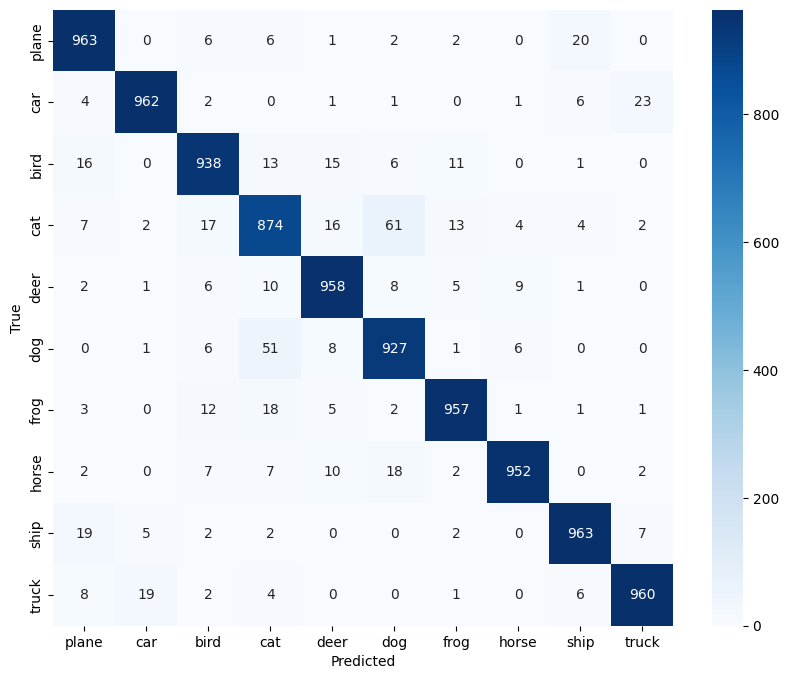

In [13]:
print("Classification Report:")
print_classification_report(resnet18, testloader, classes)
print("Confusion Matrix:")
plot_confusion_matrix(resnet18, testloader, classes)

In [14]:
def visualize_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {classes[preds[j]]}, True: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images * 2:
                    return

Sample Predictions and Misclassifications:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].


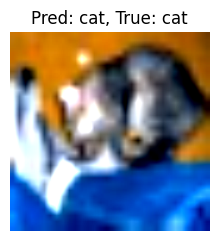

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].


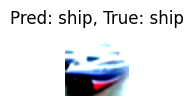

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].


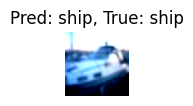

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6369936].


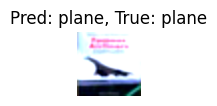

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.4079132].


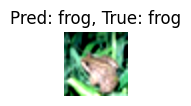

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].


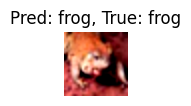

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].


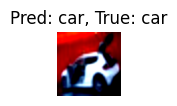

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.8025708].


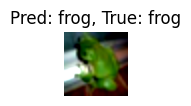

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39626682..1.6792717].


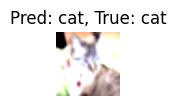

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37057972..1.7851416].


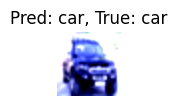

In [15]:
print("Sample Predictions and Misclassifications:")
visualize_predictions(resnet18, testloader, classes)

In [16]:
import time


def measure_inference_speed(model, dataloader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

In [17]:
inference_time_custom_cnn = measure_inference_speed(resnet18, testloader, device)
print(f'Inference Time: {inference_time_custom_cnn:.2f} seconds')


Inference Time: 36.46 seconds


In [18]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [19]:
model_size_custom_cnn = get_model_size(resnet18)
print(f'Model Size: {model_size_custom_cnn:.2f} MB')


Model Size: 42.69 MB
